# Predicting Twitch Emotes Using a Bidirectional LSTM

We implement a bidirectional LSTM neural network with one hidden layer in order to predict the emote associated to a Twitch chat message. The model used here is very rough version of what is described in the article [Towards the Understanding of Gaming Audiences by Modeling Twitch Emotes](https://pdfs.semanticscholar.org/1260/f76d10ec66dda257070ce4dcdbab800ec501.pdf) by Barbieri et al. Many parameters in this test were chosen arbitrarily, so there is a lot of room for improvement. At the end of this notebook, we evaluate the accuracy of the model by graphing epochs vs precision, recall, and F1 and displaying a confusion matrix.

Ignore the following if you are not using Google Colab.

In [ ]:
#Comment this out if not in Google Colab
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
import pandas as pd
import os

Using TensorFlow backend.


Ignore this too if you are not using Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


### Preprocessing

We need to heavily preprocess the text data before using it to train a classifier. Following Barbieri et al.'s article, we tokenize our data using the [CMU Noah's Ark tokenizer](http://www.cs.cmu.edu/~ark/TweetNLP/) developed for twitter. In the preprocessing file, we use a [python version of the tokenizer](https://pypi.org/project/twokenize/). After tokenizing, we need to remove hyperlinks, non-ASCII characters, short messages, and lowercase all words. Then we remove messages containing more than one distinct emote, and label the remaining messages as the emote contained in it. In order to avoid cheating while training our classifier, we also remove the emotes in the message. The integer argument is a threshold for which emotes to keep. We only keep emotes that appear in at least 1000 different messages after processing the data. If we apply this to summit1g's file, we obtain 4 different emotes. For example, if we change the threshold to 100, we get 32 different emotes.

In [ ]:
import preprocessing
df = preprocessing.emotes_to_labels('summit1g', 100)
print(df)

                                                      body  ...  sumg
5                                   [hope, for, 63, later]  ...     0
21       [thesocomsniper, if, you, think, oscp, is, exp...  ...     0
59                           [damn, still, playing, realm]  ...     0
238      [summit1g, lot, of, stupid, people, on, the, i...  ...     0
260                           [summit, not, in, the, bath]  ...     0
...                                                    ...  ...   ...
1349706              [the, stupid, shit, board, i, forgot]  ...     0
1349711                          [i, dont, wanna, pretend]  ...     0
1349741                            [damn, just, got, here]  ...     0
1349771                                 [we, can, pretend]  ...     0
1349815  [matthe19pizzalove, matthe19pizzalove, matthe1...  ...     0

[29468 rows x 31 columns]


In [ ]:
kappa = [i for i in df['body']]
count = 0
for i in kappa:
  for j in i:
    if j == 'lul':
      count += 1
print(count)

0


In [ ]:
df.columns

Index(['body', 'sumup', 'lul', 'residentsleeper', 'sumlul', 'sumlove', 'keepo',
       'kappa', 'sum1g', 'pogchamp', 'sums', 'sumsuh', 'notlikethis',
       'dansgame', 'babyrage', 'biblethump', 'sumthump', 'seemsgood',
       'kappapride', '4head', 'cmonbruh', 'sumw', 'sumohface', 'kreygasm',
       'sume', 'swiftrage', 'wutface', 'jebaited', 'trihard', 'failfish',
       'sumg'],
      dtype='object')

Next, we need to vectorize our lists before passing them through an embedding layer. First, we convert the tokens back into a string keeping the tokens separated by a space. That way, when we retokenize, we do not lose the effect of CMU's tokenizer. Then we transform our dataframe column into a list.

In [ ]:
df['positive'] = df['pogchamp']+df['lul'] + df['kreygasm']+df['4head']+df['kappa']+df['keepo']
df['negative'] = df['failfish'] + df['residentsleeper'] + df['cmonbruh']
df['positive'] = df['positive'].apply(lambda x: 1 if x > 0 else 0)
df['nonpositive'] = df['positive'].apply(lambda x: 1 if x == 0 else 0)
print(df['positive'])
counts = df['positive'].value_counts()
print(dict(counts))

5          0
21         1
59         0
238        1
260        1
          ..
1349706    1
1349711    0
1349741    0
1349771    0
1349815    0
Name: positive, Length: 29468, dtype: int64
{1: 20244, 0: 9224}


In [ ]:
print(df.columns)

Index(['body', 'sumup', 'lul', 'residentsleeper', 'sumlul', 'sumlove', 'keepo',
       'kappa', 'sum1g', 'pogchamp', 'sums', 'sumsuh', 'notlikethis',
       'dansgame', 'babyrage', 'biblethump', 'sumthump', 'seemsgood',
       'kappapride', '4head', 'cmonbruh', 'sumw', 'sumohface', 'kreygasm',
       'sume', 'swiftrage', 'wutface', 'jebaited', 'trihard', 'failfish',
       'sumg', 'positive', 'negative', 'nonpositive'],
      dtype='object')


In [ ]:
Z = df['body'].values.tolist()
Z = [' '.join(i) for i in Z]

Using the tokenizer from keras, we tokenize and keep the 5000 most frequent words, using 5001 for our out-of-vocabulary token. Then we convert the tokens to a sequence using their corresponding integer ids.

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer(num_words=5000, filters='', split=' ', oov_token=5001)
t.fit_on_texts(Z)
sequences = t.texts_to_sequences(Z)

Now we are ready to split our training set and pad our sequences. The values for top_words and max_words can be changed as desired.

In [ ]:
from sklearn.model_selection import train_test_split
X = sequences
y = np.array(df.iloc[:,-3])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

top_words = 5001
max_words = 20
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

One important observation is that our data is imbalanced. Some emotes appear far more often than others, even after cleaning the data. We use an oversampling technique called [Synthetic Minority Over-sampling Technique](https://jair.org/index.php/jair/article/view/10302/24590) (SMOTE). We need to apply it to both our training and testing data in order to get meaningful evaluation data.

In [ ]:
print(X_train[:5])

[[   0    0    0    0    0    0    0    0    0    0    0    9  181 3949
    43    2 1831   20   11 2011]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0   21   32 1391]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0  124
    16  128   84   78   65   11]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  773  157   25    2  755]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 2118  113  133   12]]


In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
# transform the dataset
X_train, y_train = oversample.fit_resample(X_train, y_train)
# X_test, y_test = oversample.fit_resample(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(X_train)

[[   0    0    0 ... 4670    1   11]
 [   0    0    0 ...    5    4  479]
 [   0    0    0 ...   99   19  395]
 ...
 [   0    0    0 ...   43  455 1932]
 [   0    0    0 ...  291  175  159]
 [   0    0    0 ... 3166   20 3252]]


### Bidirection LSTM

We use a very simply neural network. In NLP classification problems, it is common to use bidirectional recurrent neural networks since meaning depends on words appearing early and late in sentences. LSTM cells are also a common choice in NLP since they can detect long-range dependencies in language, which regular RNN's cannot do.

In [ ]:
model1 = Sequential()
model1.add(Embedding(top_words, 100, input_length=max_words))
model1.compile(optimizer='RMSprop', loss='mse', metrics=['acc'])

output = model1.predict(X_train)
print(output.shape)
print(output[0])

(28182, 20, 100)
[[-0.04461325  0.04772505 -0.03827719 ... -0.00607816 -0.03519604
  -0.02504243]
 [-0.04461325  0.04772505 -0.03827719 ... -0.00607816 -0.03519604
  -0.02504243]
 [-0.04461325  0.04772505 -0.03827719 ... -0.00607816 -0.03519604
  -0.02504243]
 ...
 [ 0.01622007 -0.02488015 -0.03476064 ...  0.04582847  0.01300298
  -0.00588084]
 [-0.00595459 -0.02187537 -0.00621422 ...  0.01942896 -0.00038453
  -0.00957251]
 [-0.01420964 -0.01025058  0.04099207 ...  0.01376157 -0.0227755
  -0.04478663]]


In [ ]:
model = Sequential()
model.add(Embedding(top_words, 100, input_length=max_words))
model.add(Bidirectional(LSTM(100,activation='relu',return_sequences=True),input_shape=(100, 1)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Finally, we fit our model and keep track of precision, recall, and F1 scores accross epochs.

In [ ]:
from keras import backend as K
from keras import optimizers


# compile the model
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])

# fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)


Train on 30366 samples, validate on 7367 samples
Epoch 1/10
30366/30366 [==============================] - 80s 3ms/step - loss: 4.5990 - acc: 0.6018 - val_loss: 0.6040 - val_acc: 0.6992
Epoch 2/10
30366/30366 [==============================] - 75s 2ms/step - loss: 0.5833 - acc: 0.7050 - val_loss: 0.6087 - val_acc: 0.6934
Epoch 3/10
30366/30366 [==============================] - 75s 2ms/step - loss: 0.5374 - acc: 0.7436 - val_loss: 0.6147 - val_acc: 0.6810
Epoch 4/10
30366/30366 [==============================] - 75s 2ms/step - loss: 1.2557 - acc: 0.7673 - val_loss: 0.6567 - val_acc: 0.6503
Epoch 5/10
30366/30366 [==============================] - 75s 2ms/step - loss: 110.2474 - acc: 0.7795 - val_loss: 3.9578 - val_acc: 0.6659
Epoch 6/10
30366/30366 [==============================] - 74s 2ms/step - loss: 168.0427 - acc: 0.7866 - val_loss: 7.6520 - val_acc: 0.6554
Epoch 7/10
30366/30366 [==============================] - 74s 2ms/step - loss: 17409674.1946 - acc: 0.7942 - val_loss: 0.6762

# New Section

In [ ]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


### Evaluation

Now that we have trained our model, we can evaluate its accuracy. We plot the accuracy of our model using the test date. Note that accuracy and precision decays while recall and F1 drastically improve over epochs.

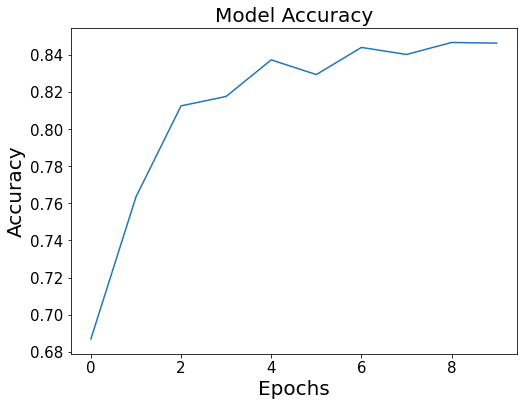

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.tick_params(labelsize=15)
# plt.show()
plt.savefig('model_accuracy.png')

Our confusion matrix shows that the correct label is most frequently assigned across all labels, but there is plenty of misclassification. Aside from non-optimal model selection and imbalanced data, we can reason that the data is very noisy (which we already knew), making it difficult for the model to learn from it. The number of messages used before oversampling was approximately 20000 out of the 1.3 million total messages in the data, and accuracy was still a problem. In conclusion, there is still a lot to improve upon in our cleaning methods and model selection.

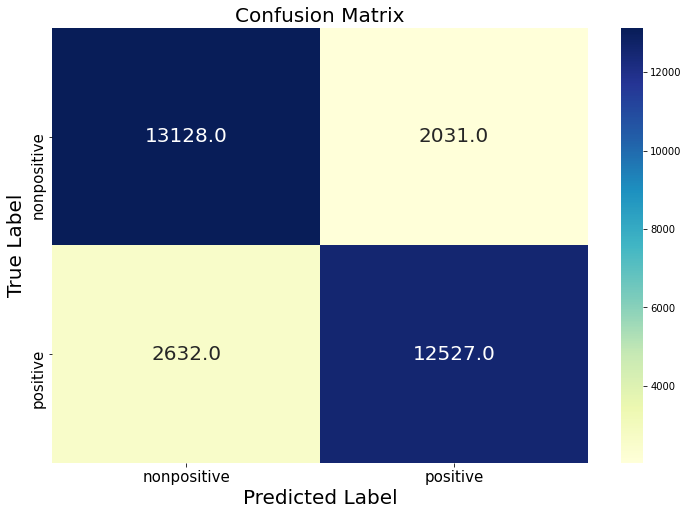

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


y_pred = model.predict(X_test)
y_pred_class = np.round(y_pred)
y_true = y_test

confusion = confusion_matrix(y_true, y_pred_class)

f, ax = plt.subplots(figsize= (12,8))
sns.heatmap(confusion, annot = True, cmap = "YlGnBu", ax = ax, xticklabels=['nonpositive','positive'], yticklabels=['nonpositive','positive'], annot_kws={"size": 20}, fmt= '.1f')

plt.xlabel("Predicted Label",fontsize=20)
plt.ylabel("True Label",fontsize=20)
plt.title("Confusion Matrix",fontsize=20)
plt.tick_params(labelsize=15)

plt.savefig('cm.png')